In [1]:
import os
import pandas as pd
os.chdir("E:\\Projects\\diffusion")
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import warnings
from tqdm.auto import tqdm
import numpy as np
from diffusers.utils import randn_tensor
from stadiff.models import SpaUNet1DModel
from stadiff.pipeline import prepare_dataset
import torch.nn.functional as F
from diffusers import DDPMScheduler
from collections import defaultdict
from torch_geometric.loader import NeighborLoader
from stadiff.analytics import mclust_R
from stadiff import utils
os.environ["R_HOME"] = r"D:\Program Files\R\R-4.0.3"
warnings.filterwarnings("ignore")
sns.set_theme("paper", style="ticks", font_scale=1.25)

In [194]:
DATA_DIR = "E:\\Projects\\Datasets\\her2st\\"
class Her2stSlice:
    def __init__(self, name, data_dir=None):
        self.name = name
        self.cnts_dir = os.path.join(data_dir, "data\\ST-cnts")
        self.imgs_dir = os.path.join(data_dir, "data\\ST-imgs")
        self.spots_dir = os.path.join(data_dir, "data\\ST-spotfiles")
        self.lbl_dir = os.path.join(data_dir, "res\\ST-cluster\\lbl")
        self._adata = None

    def get_spatial(self):
        return pd.read_csv(os.path.join(self.spots_dir, f"{self.name}_selection.tsv"), sep="\t", index_col=False)

    def get_counts(self):
        return pd.read_csv(os.path.join(self.cnts_dir, f"{self.name}.tsv"), sep="\t", index_col=0)

    def get_lbl(self):
        return pd.read_csv(os.path.join(self.lbl_dir, f"{self.name}-cluster-annotation.tsv.gz"), sep="\t", index_col=0)

    def _load_adata(self):
        spatial = self.get_spatial()
        counts = self.get_counts()
        labels = self.get_lbl()
        adata = sc.AnnData(counts)
        spatial.index = spatial.apply(lambda x: "{:.0f}x{:.0f}".format(x["x"], x["y"]), axis=1)
        adata.obs = spatial.loc[adata.obs.index, :]
        labels.index = labels.apply(lambda x: "{:.0f}x{:.0f}".format(x["x"], x["y"]), axis=1)
        labels = labels.loc[:, ["patient_id", "ids", "label"]]
        labels["label"] = labels["label"].astype("category")
        adata.obs = adata.obs.merge(labels, left_index=True, right_index=True, how="left")
        adata.obs_names = self.name + "_" + adata.obs.index
        adata.obsm["spatial"] = adata.obs.loc[:, ["new_x", "new_y"]].values
        return adata

    @property
    def adata(self):
        if self._adata is None:
            self._adata = self._load_adata()
        return self._adata

# Analysis on patient A

In [210]:
labels_dict = {
    0: "cancer 1",
    1: "cancer 2",
    2: "connective tissue",
    3: "immune : B/plasma cells",
    4: "immune : APC",
    5: "cancer in situ",
}

In [222]:
slice_names = ["A1", "A2", "A3", "A4", "A5", "A6"]
adata_list = [Her2stSlice(name, data_dir=DATA_DIR).adata for name in slice_names]
adata = sc.concat(adata_list)
# remove rows contain NA
adata = adata[~adata.obs["label"].isna(), :]
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor="seurat_v3")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = adata[:, adata.var["highly_variable"]]

In [231]:
# perform PCA
sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata, n_neighbors=30, use_rep="X_pca")
sc.tl.umap(adata)

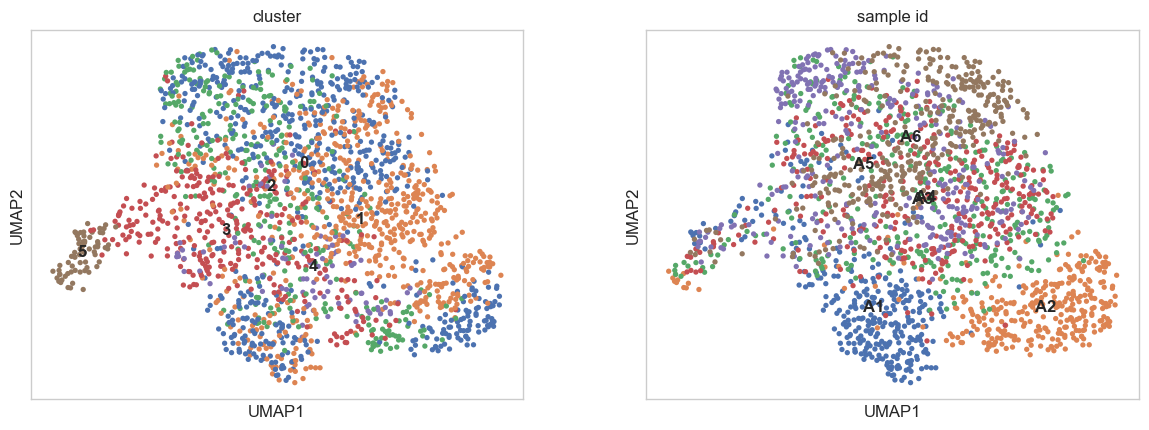

In [233]:
sc.pl.umap(adata, color=["label", "ids"], legend_loc="on data", title=["cluster", "sample id"])

The data demonstrates batch effect. We will use triplet loss to mitigate the batch effect.

## Pretraining the autoencoder on each slice

In [258]:
from stadiff.vae import SpaAE
from stadiff.dataset import get_slice_loader
from stadiff import pipeline
model_config = {"pretrain_epochs": 500,
                "align_epochs": 500,
                "diffusion_epochs": 2000,
                "gradient_clip": 5,
                "save_dir": "E:\Projects\diffusion\output\Multi-slice-breast-cancer",
                }
save_dir = model_config["save_dir"]
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
device = torch.device("cuda:0")
iter_comb = [(slice_names[i], slice_names[i+1]) for i in range(len(slice_names)-1)]
adata = utils.cal_spatial_net3D(adata, iter_comb=None, batch_id="ids", rad_cutoff=1.45)

------Calculating spatial network for each batch...
Calculating spatial network for batch A1...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 2094 edges, 345 cells, 6.0696 neighbors per cell on average.
Calculating spatial network for batch A2...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 2030 edges, 323 cells, 6.2848 neighbors per cell on average.
Calculating spatial network for batch A3...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 2210 edges, 356 cells, 6.2079 neighbors per cell on average.
Calculating spatial network for batch A4...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 2080 edges, 341 cells, 6.0997 neighbors per cell on average.
Calculating spatial network for batch A5...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 2020 edges, 329 cells, 6.1398 neighbors per cell on av

In [259]:
spatial_data = adata.obsm["spatial"]
new_spatial_data = utils.quantize_coordination(spatial_data, [("division", 1), ("division", 1)])
adata.obsm["spatial_new"] = new_spatial_data
data = pipeline.prepare_dataset(adata, use_net="Spatial_Net", use_spatial="spatial_new", device=device)

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 1.0, mean deviation is 0.09311896635787402
Quantize 1th dimension of spatial coordinates to 1.0, mean deviation is 0.065366650414432


In [260]:
model = SpaAE(input_dim=1000,
               block_list=["ResBlock"],
               gat_dim=[512, 32],
               block_out_dims=[32, 32]).to(device)
train_loaders = [get_slice_loader(adata, data, slice_names[ind], use_batch="ids") for ind in range(len(slice_names))]
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
n_epochs = model_config["pretrain_epochs"]
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
loss_list = []
pbar = tqdm(range(n_epochs))
model.train()
for epoch in range(1, n_epochs + 1):
    for train_loader in train_loaders:
        for batch in train_loader:
            optimizer.zero_grad()
            z, out = model(batch.x, batch.edge_index)
            loss = F.mse_loss(out, batch.x)
            loss_list.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            pbar.set_description(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
            loss_list.append(loss.item())
        scheduler.step()
    pbar.update(1)
torch.save(model, os.path.join(save_dir, "pretrain_autoencoder.pth"))
# save model to disk

  0%|          | 0/500 [00:00<?, ?it/s]

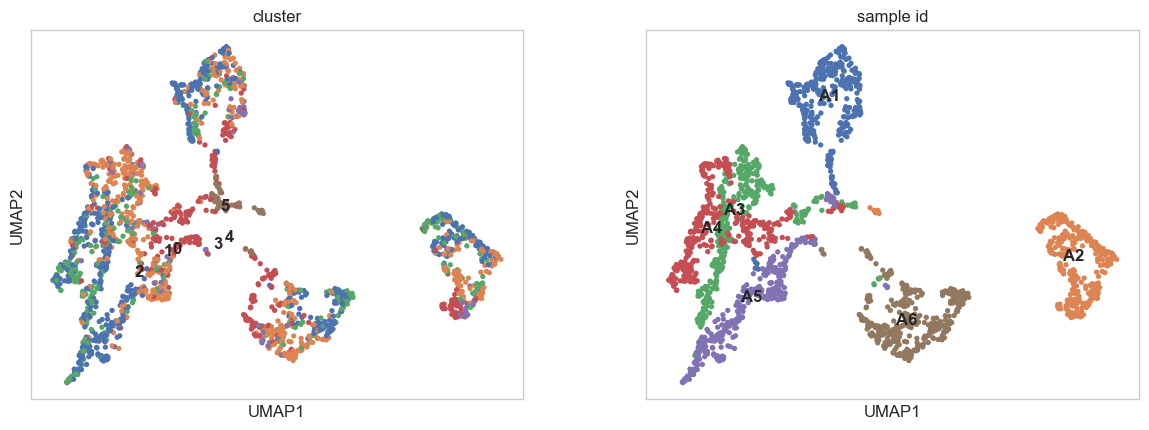

In [264]:
with torch.no_grad():
    model.eval()
    with torch.no_grad():
        z, out = model(data.x, data.edge_index)
    adata.obsm["latent"] = z.detach().cpu().numpy()
sc.pp.neighbors(adata, n_neighbors=30, use_rep="latent")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["label", "ids"], legend_loc="on data", title=["cluster", "sample id"])

## Aligning the latent space by triplet loss

In [267]:
from stadiff.dataset import TripletSampler

def get_rep(model, data, adata, add_key):
    model.eval()
    with torch.no_grad():
        z, out = model(data.x, data.edge_index)
    adata.obsm[add_key] = z.detach().cpu().numpy()
    return adata

In [270]:
train_loaders = []
index_mappings = []
iter_combs = [(i, i+1) for i in range(len(slice_names)-1)]
for batch_name in slice_names:
    num_spots = int(adata.obs["ids"].value_counts()[batch_name])
    loader = get_slice_loader(adata, data, batch_name, batch_size=num_spots, use_batch="ids")
    train_loaders.append(loader)
    batch = next(iter(loader))
    index_mappings.append({val.item(): idx for idx, val in enumerate(batch.n_id)})

In [271]:
import torch.nn as nn
loss_list = []
n_epochs = model_config["align_epochs"]
pbar = tqdm(range(n_epochs))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
triplet_loss = nn.TripletMarginLoss(margin=1, p=2)
update_mnn_eval = 100

for epoch in range(1, n_epochs + 1):
    if epoch % update_mnn_eval == 1:
        # update the representation
        print("Updating the representation")
        adata = get_rep(model, data, adata, "latent")
        tri_samplers = []
        for (target_id, ref_id) in iter_combs:
            tri_samplers.append(TripletSampler(adata, data, target=slice_names[target_id],
                                               use_rep="latent",
                                               reference=slice_names[ref_id],
                                               use_batch="ids",
                                               num_neighbors=15))
    model.train()
    for ind, (target_id, ref_id) in enumerate(iter_combs):
        optimizer.zero_grad()
        target_batch = next(iter(train_loaders[target_id]))
        reference_batch = next(iter(train_loaders[ref_id]))
        z_target, out_target = model(target_batch.x, target_batch.edge_index)
        z_reference, out_reference = model(reference_batch.x, reference_batch.edge_index)
        anchor_indices, positive_indices, negative_indices = tri_samplers[ind].query(target_batch.n_id.detach().cpu().numpy())
        anchor_indices = [index_mappings[target_id][i] for i in anchor_indices]
        positive_indices =  [index_mappings[ref_id][i] for i in positive_indices]
        negative_indices = [index_mappings[target_id][i] for i in negative_indices]
        loss_rmse = F.mse_loss(out_target, target_batch.x) * .5 + F.mse_loss(out_reference, reference_batch.x) * .5
        z_a = z_target[anchor_indices]
        z_p = z_reference[positive_indices]
        z_n = z_target[negative_indices]
        loss_tri = triplet_loss(z_a, z_p, z_n)
        loss = loss_tri + loss_rmse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        pbar.set_description(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
        loss_list.append(loss.item())
        scheduler.step()
    pbar.update(1)
torch.save(model, os.path.join(model_config["save_dir"], "aligned_autoencoder.pth"))

  0%|          | 0/500 [00:00<?, ?it/s]

Updating the representation
Updating the representation
Updating the representation
Updating the representation
Updating the representation


R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


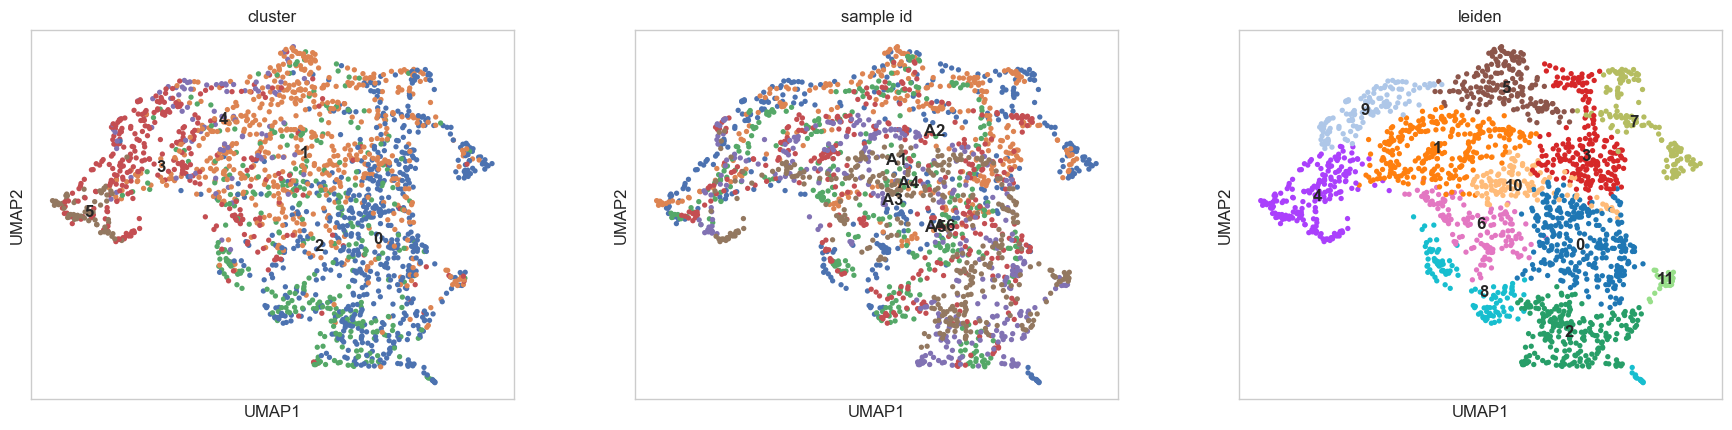

In [286]:
with torch.no_grad():
    model.eval()
    with torch.no_grad():
        z, out = model(data.x, data.edge_index)
    adata.obsm["latent"] = z.detach().cpu().numpy()
sc.pp.neighbors(adata, n_neighbors=30, use_rep="latent")
sc.tl.umap(adata, min_dist=0.5)
# perform leiden clustering
adata = mclust_R(adata, 6, use_rep="latent", add_key="mclust")

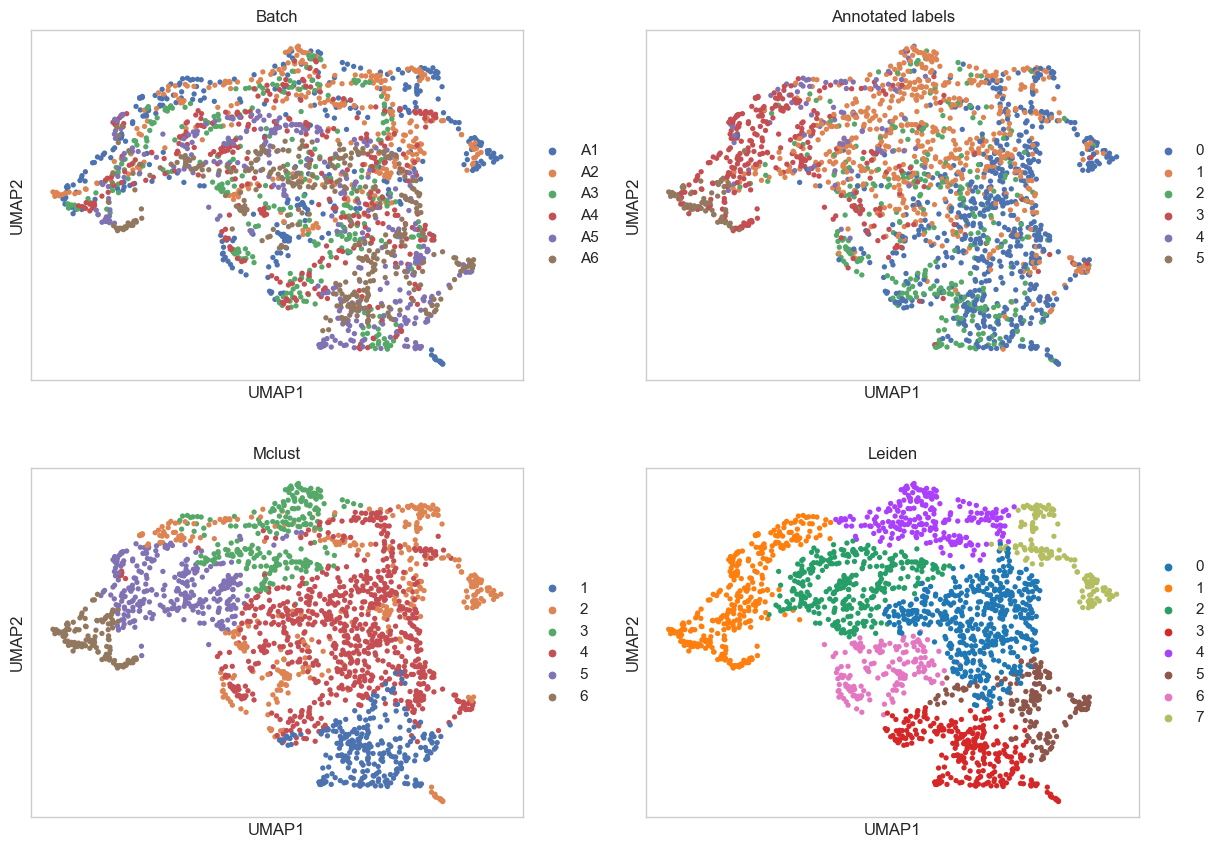

In [294]:
sc.tl.leiden(adata, key_added="leiden", resolution=0.35)
sc.pl.umap(adata, color=["ids", "label", "mclust", "leiden"],
           title=["Batch", "Annotated labels", "Mclust", "Leiden"], ncols=2)

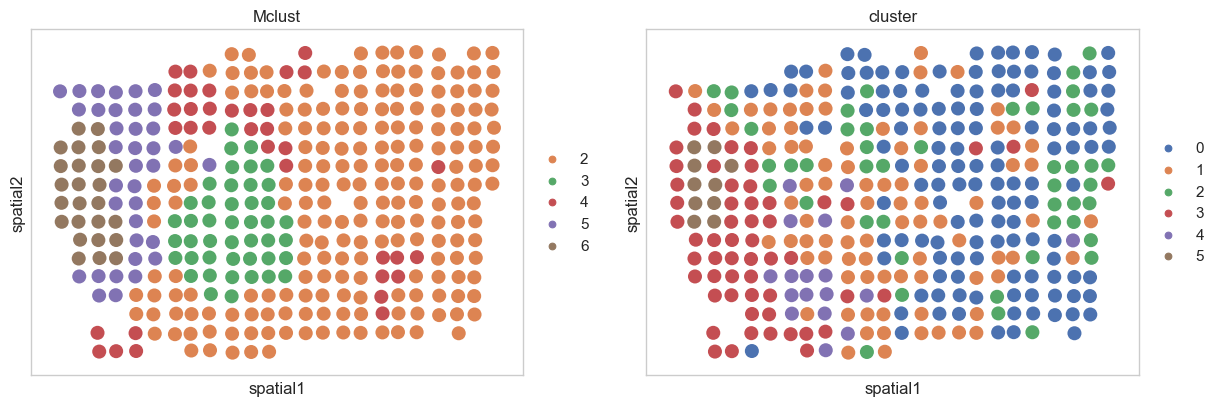

In [295]:
sub_adata = adata[adata.obs["ids"] == "A1", :]
# plot spatial
sc.pl.spatial(sub_adata, color=["mclust", "label"],  title=["Mclust", "cluster"], spot_size=0.75)

In [296]:
# compute ari
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(adata.obs["mclust"], adata.obs["label"]), adjusted_rand_score(adata.obs["leiden"], adata.obs["label"])

(0.12532849587380576, 0.1354602115370314)

In [297]:
my_adata = sc.read_h5ad("E:\\Projects\\diffusion\\dataset\\STARmap_20180505_BY3_1k.h5ad")

In [301]:
my_adata.obs

,Total_counts,X,Y,label,region,Region
Cell_9,310,4980.777664,-49.771247,L6,L6,L6
Cell_10,533,8729.177425,-53.473114,L4,L4,L4
Cell_13,452,11547.566359,-46.315493,L2/3,L2/3,L2/3
Cell_15,288,3280.980264,-37.612811,L6,L6,L6
Cell_16,457,7582.793601,-45.350312,L4,L4,L4
...,...,...,...,...,...,...
Cell_1382,591,3586.132257,-6400.348920,L6,L6,L6
Cell_1383,336,4005.014202,-6404.411871,L6,L6,L6
Cell_1385,392,9495.290017,-6404.294179,L2/3,L2/3,L2/3
Cell_1387,334,13653.531752,-6418.719694,L1,L1,L1
